1. Nama : Sri Kresna Maha Dewa
2. email : srikresna383@gmail.com
3. TTL : Sidoarjo, 03 Agustus 2003
4. Instansi : Politeknik Negeri Malang

In [34]:
!pip install -q kaggle

In [35]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"srikresna","key":"c90f9c19af6b129911ae9410dd23cde4"}'}

In [36]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [14]:
!kaggle datasets download -d mrutyunjaybiswal/iitjee-neet-aims-students-questions-data

100% 9.60M/9.60M [00:01<00:00, 12.0MB/s]
100% 9.60M/9.60M [00:01<00:00, 6.89MB/s]


In [15]:
!unzip iitjee-neet-aims-students-questions-data.zip

Archive:  iitjee-neet-aims-students-questions-data.zip
  inflating: subjects-questions.csv  


In [20]:
import pandas as pd

df = pd.read_csv('subjects-questions.csv')
df

,eng,Subject
0,An anti-forest measure is\nA. Afforestation\nB...,Biology
1,"Among the following organic acids, the acid pr...",Chemistry
2,If the area of two similar triangles are equal...,Maths
3,"In recent year, there has been a growing\nconc...",Biology
4,Which of the following statement\nregarding tr...,Physics
...,...,...
122514,Which of the following group of\ncharacters is...,Biology
122515,Light year is the\nA. light emitted by the sun...,Physics
122516,Member of Dipnoi are native of\nA. India.\nB. ...,Biology
122517,"In one average-life,\nA. half the active nucle...",Physics


In [21]:
#one hot encoding
category = pd.get_dummies(df.Subject)
df_baru = pd.concat([df, category], axis = 1)
df_baru = df_baru.drop(columns = 'Subject')

df_baru

,eng,Biology,Chemistry,Maths,Physics
0,An anti-forest measure is\nA. Afforestation\nB...,1,0,0,0
1,"Among the following organic acids, the acid pr...",0,1,0,0
2,If the area of two similar triangles are equal...,0,0,1,0
3,"In recent year, there has been a growing\nconc...",1,0,0,0
4,Which of the following statement\nregarding tr...,0,0,0,1
...,...,...,...,...,...
122514,Which of the following group of\ncharacters is...,1,0,0,0
122515,Light year is the\nA. light emitted by the sun...,0,0,0,1
122516,Member of Dipnoi are native of\nA. India.\nB. ...,1,0,0,0
122517,"In one average-life,\nA. half the active nucle...",0,0,0,1


In [24]:
df_baru['eng'] = df_baru['eng'].str.lower()
length = df['eng'].str.len().max()
df_baru.columns

Index(['eng', 'Biology', 'Chemistry', 'Maths', 'Physics'], dtype='object')

In [26]:
#ubah menjadi numpy array
news = df_baru['eng'].values
label = df_baru[['Biology', 'Chemistry', 'Maths', 'Physics']].values
label

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       ...,
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=uint8)

In [27]:
#pisahkan menjadi train & test
from sklearn.model_selection import train_test_split
news_train, news_test, label_train, label_test = train_test_split(news, label, test_size = 0.2, random_state = 123)

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#tokenisasi
tokenizer = Tokenizer(num_words = length, oov_token = '', filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~ ')
tokenizer.fit_on_texts(news_train)
tokenizer.fit_on_texts(news_test)

sequences_train = tokenizer.texts_to_sequences(news_train)
sequences_test = tokenizer.texts_to_sequences(news_test)

padded_train = pad_sequences(sequences_train)
padded_test = pad_sequences(sequences_test)


In [29]:
import tensorflow as tf

#bangun model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [30]:
#compile

model.compile(loss ='categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [31]:
#cek model

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          80000     
                                                                 
 lstm_2 (LSTM)               (None, 64)                20736     
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 4)                 516       
                                                                 
Total params: 109,572
Trainable params: 109,572
Non-trainable params: 0
_________________________________________________________________


In [32]:
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping

#Callback Function
class accCallback(Callback):
   def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') >= 0.90 and logs.get('val_accuracy') >= 0.90):
            print("\nAccuracy and Val_Accuracy has reached 90%!", "\nEpoch: ", epoch)
            self.model.stop_training = True

callbacks = accCallback()

auto_reduction_LR = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 2, #setelah 2 epoch, jika tidak ada kenaikan maka LR berkurang
    verbose = 1,
    factor = 0.2,
    min_lr = 0.000003
)

auto_stop_learn = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0,
    patience = 4,
    verbose = 1,
    mode = 'auto' 
)

#latih model
history = model.fit(padded_train, label_train,
                    steps_per_epoch = 30,
                    epochs = 100,
                    validation_data = (padded_test, label_test),
                    verbose = 1,
                    validation_steps = 50,
                    callbacks=[callbacks, auto_reduction_LR, auto_stop_learn], 
                    )

Epoch 1/100
30/30 [==============================] - 15s 429ms/step - loss: 1.3070 - accuracy: 0.3515 - val_loss: 1.8798 - val_accuracy: 0.2680 - lr: 0.0010
Epoch 2/100
30/30 [==============================] - 13s 438ms/step - loss: 1.1204 - accuracy: 0.5155 - val_loss: 0.9211 - val_accuracy: 0.5968 - lr: 0.0010
Epoch 3/100
30/30 [==============================] - 13s 431ms/step - loss: 0.9063 - accuracy: 0.6064 - val_loss: 0.7551 - val_accuracy: 0.6853 - lr: 0.0010
Epoch 4/100
30/30 [==============================] - 12s 414ms/step - loss: 0.7238 - accuracy: 0.7031 - val_loss: 0.6294 - val_accuracy: 0.7578 - lr: 0.0010
Epoch 5/100
30/30 [==============================] - 12s 413ms/step - loss: 0.5615 - accuracy: 0.7945 - val_loss: 0.5951 - val_accuracy: 0.7592 - lr: 0.0010
Epoch 6/100
30/30 [==============================] - 12s 410ms/step - loss: 0.4782 - accuracy: 0.8287 - val_loss: 0.4202 - val_accuracy: 0.8566 - lr: 0.0010
Epoch 7/100
30/30 [==============================] - 12s 4

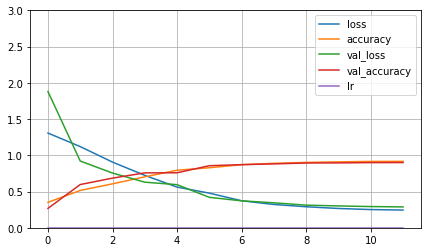

In [33]:
#plotting
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(7, 4))
plt.grid(True)
plt.gca().set_ylim(0,3) #sumbu y

plt.show()